# Stage 2b: Generate AI Alpha Factors

- Compute target values (y)
    - Quantize with 2 bins for testing
    - Quantize with 25 bins for production
- Train model for Feature importance
- Feature reduction
- Train model for AI Alpha Vector
- Compute AI Alpha Vectors for 1 year
- Save AI Alpha Vectors

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---9216'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

# Price History data from Stage 1

In [3]:
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks')
print(pricing.columns.to_list())
pricing.tail()

Date range for price histories: 2016-07-20 to 2021-07-20
You have 500 stocks
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL
date,,,,,,,,,,,,,,,,,,,,,
2021-07-14 00:00:00+00:00,148.63,20.62,210.16,149.150,117.36,113.56,312.30,117.17,314.390,608.83,...,51.260,371.44,23.580,34.70,110.7100,68.09,132.74,59.530,62.16,121.01
2021-07-15 00:00:00+00:00,148.96,20.46,209.25,148.480,117.18,113.16,310.19,116.66,314.940,606.17,...,50.290,371.96,23.440,34.63,108.2300,68.72,129.71,58.950,61.80,120.01
2021-07-16 00:00:00+00:00,148.93,19.79,205.85,146.390,117.50,112.88,317.98,117.51,311.910,606.10,...,49.010,373.66,23.500,34.02,104.7000,69.13,128.63,57.320,61.16,119.36
2021-07-19 00:00:00+00:00,147.58,18.97,205.67,142.450,115.42,112.60,314.62,118.79,309.180,602.05,...,47.990,371.00,22.720,32.95,104.7400,68.27,129.33,55.350,60.69,117.23
2021-07-20 00:00:00+00:00,149.59,20.20,211.18,146.765,115.94,116.67,323.96,118.82,313.815,610.37,...,48.665,375.57,23.105,33.52,106.3567,68.66,130.92,56.165,62.55,121.55


## Read existing factors

In [4]:
all_factors = pd.read_csv('data/all_factors.csv', parse_dates=['date'])
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_assets = all_factors.index.levels[1].values.tolist()
print(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')
print(f'Stocks: {all_assets}')
all_factors.sort_values(['ticker', 'date']).tail(10)

Factors from date: 2017-07-20 00:00:00+00:00 to date: 2021-07-20 00:00:00+00:00
Stocks: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', '

,,momentum_252_day_logret,mean_reversion_5_day_logret_smoothed,overnight_sentiment_5_day_smoothed,annualzed_volatility_20_day,annualzed_volatility_120_day,average_dollar_volume_20_day,average_dollar_volume_120_day,market_dispersion20_day,market_dispersion120_day,market_volatility20_day,market_volatility120_day,is_January,is_December,weekday,quarter,year,month_start,month_end,quarter_start,quarter_end
date,ticker,,,,,,,,,,,,,,,,,,,,
2021-07-07 00:00:00+00:00,XYL,1.160476,-0.599291,1.444533,-1.631595,-1.479174,-0.938773,-1.250543,0.012881,0.016539,0.087972,0.102633,0,0,2,3,2021,0,0,0,0
2021-07-08 00:00:00+00:00,XYL,1.215902,-0.557721,1.472246,-1.610810,-1.520744,-0.938773,-1.250543,0.012832,0.016465,0.092767,0.103807,0,0,3,3,2021,0,0,0,0
2021-07-09 00:00:00+00:00,XYL,1.084266,-0.592363,1.402964,-1.700877,-1.541528,-0.917989,-1.257471,0.012729,0.016421,0.104747,0.104864,0,0,4,3,2021,0,0,0,0
2021-07-12 00:00:00+00:00,XYL,1.153548,-0.661645,1.382179,-1.659308,-1.576169,-0.924917,-1.257471,0.012669,0.016348,0.104090,0.104539,0,0,0,3,2021,0,0,0,0
2021-07-13 00:00:00+00:00,XYL,1.139692,-0.689358,1.264400,-1.631595,-1.576169,-0.904132,-1.257471,0.012586,0.016292,0.108277,0.105004,0,0,1,3,2021,0,0,0,0
2021-07-14 00:00:00+00:00,XYL,0.862563,-0.827922,1.125835,-1.596954,-1.583098,-0.876419,-1.250543,0.012697,0.016262,0.109875,0.104522,0,0,2,3,2021,0,0,0,0
2021-07-15 00:00:00+00:00,XYL,0.897204,-0.883348,0.917989,-1.465318,-1.631595,-0.876419,-1.264400,0.012811,0.016256,0.106578,0.104343,0,0,3,3,2021,0,0,0,0
2021-07-16 00:00:00+00:00,XYL,0.945702,-0.959558,0.668573,-1.299041,-1.652380,-0.869491,-1.264400,0.012416,0.016236,0.105082,0.105340,0,0,4,3,2021,0,0,0,0
2021-07-19 00:00:00+00:00,XYL,0.973415,-0.987271,0.453798,-1.354466,-1.680093,-0.883348,-1.271328,0.012572,0.016181,0.106672,0.107164,0,0,0,3,2021,0,0,0,0


## Compute the target values (y) and Shift back to create a 5 day forward prediciton

This is something you want to experiment with. If you are planning on holding on to assets for long periods of time, perhaps a 20, 40 or 60 forward prediciton will work better.

In [5]:
target_source = '5Day2Quant'
forward_prediciton_days = 5

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, 2, 5).for_al(target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)
display(all_factors.head())

all_factors['target'] = all_factors.groupby(level='ticker')[target_source].shift(-forward_prediciton_days)
all_factors[[target_source,'target']].reset_index().sort_values(['ticker', 'date']).tail(10)

momentum_252_day_logret  \
date                      ticker                            
2017-07-20 00:00:00+00:00 A                      0.710144   
                          AAL                    1.229761   
                          AAP                   -1.687024   
                          AAPL                   1.396039   
                          ABBV                   0.072746   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2017-07-20 00:00:00+00:00 A                                  -0.779426   
                          AAL                                -1.638527   
                          AAP                                 1.728594   
                          AAPL                               -1.139694   
                          ABBV                               -0.495369   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2017-07-20 00:00:00+00:00 A                                 1.292112   
                          AAL                               0.675501   
                          AAP                              -1.132763   
                          AAPL                             -1.451461   
                          ABBV                             -0.917989   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2017-07-20 00:00:00+00:00 A                         -0.239024   
                          AAL                        0.807139   
                          AAP                        1.520747   
                          AAPL                       1.264402   
                          ABBV                       0.647790   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2017-07-20 00:00:00+00:00 A                           0.287522   
                          AAL                         0.419158   
                          AAP                         1.603885   
                          AAPL                       -0.620077   
                          ABBV                        0.370660   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2017-07-20 00:00:00+00:00 A                          -0.412230   
                          AAL                         1.035771   
                          AAP                         0.793282   
                          AAPL                        1.728594   
                          ABBV                        1.195120   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2017-07-20 00:00:00+00:00 A                           -0.550794   
                          AAL                          1.021914   
                          AAP                          0.495369   
                          AAPL                         1.728594   
                          ABBV                         1.250546   

                                  market_dispersion20_day  \
date                      ticker                            
2017-07-20 00:00:00+00:00 A                      0.012224   
                          AAL                    0.012224   
                          AAP                    0.012224   
                          AAPL                   0.012224   
                          ABBV                   0.012224   

                                  market_dispersion120_day  \
date                      ticker                             
2017-07-20 00:00:00+00:00 A                       0.012114   
                          AAL                     0.012114   
                          AAP                     0.01

,date,ticker,5Day2Quant,target
498999,2021-07-07 00:00:00+00:00,XYL,1,1.0
499499,2021-07-08 00:00:00+00:00,XYL,0,0.0
499999,2021-07-09 00:00:00+00:00,XYL,1,0.0
500499,2021-07-12 00:00:00+00:00,XYL,1,0.0
500999,2021-07-13 00:00:00+00:00,XYL,1,1.0
501499,2021-07-14 00:00:00+00:00,XYL,1,NaN
501999,2021-07-15 00:00:00+00:00,XYL,0,NaN
502499,2021-07-16 00:00:00+00:00,XYL,0,NaN
502999,2021-07-19 00:00:00+00:00,XYL,0,NaN
503499,2021-07-20 00:00:00+00:00,XYL,1,NaN


### IID Check of Target
Let's see if the returns are independent and identically distributed.

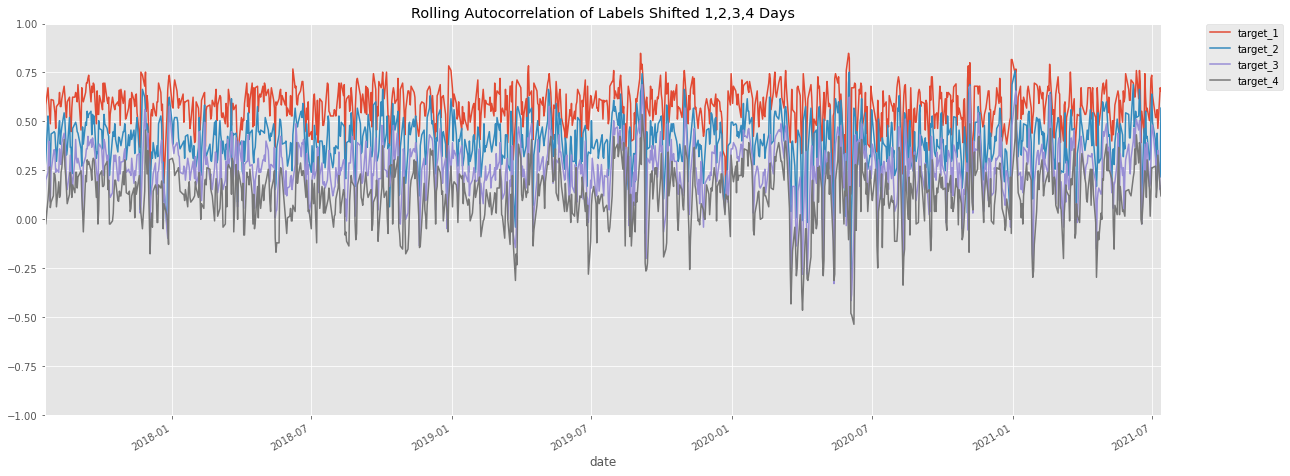

In [6]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]


all_factors['target_1'] = all_factors.groupby(level='ticker')[target_source].shift(-4)
all_factors['target_2'] = all_factors.groupby(level='ticker')[target_source].shift(-3)
all_factors['target_3'] = all_factors.groupby(level='ticker')[target_source].shift(-2)
all_factors['target_4'] = all_factors.groupby(level='ticker')[target_source].shift(-1)

g = all_factors.dropna().groupby(level='date')
for i in range(4):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, 'target', label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

## Evaluate Autocorrelation IID Results

As you can see, the further out from the target (target_4) we are the less correlated the data is.

In [7]:
all_factors.columns.values

array(['momentum_252_day_logret', 'mean_reversion_5_day_logret_smoothed',
       'overnight_sentiment_5_day_smoothed',
       'annualzed_volatility_20_day', 'annualzed_volatility_120_day',
       'average_dollar_volume_20_day', 'average_dollar_volume_120_day',
       'market_dispersion20_day', 'market_dispersion120_day',
       'market_volatility20_day', 'market_volatility120_day',
       'is_January', 'is_December', 'weekday', 'quarter', 'year',
       'month_start', 'month_end', 'quarter_start', 'quarter_end',
       '5Day2Quant', 'target', 'target_1', 'target_2', 'target_3',
       'target_4'], dtype=object)

In [8]:
features = ['momentum_252_day_logret', 'mean_reversion_5_day_logret_smoothed',
       'overnight_sentiment_5_day_smoothed',
       'annualzed_volatility_20_day', 'annualzed_volatility_120_day',
       'average_dollar_volume_20_day', 'average_dollar_volume_120_day',
       'market_dispersion20_day', 'market_dispersion120_day',
       'market_volatility20_day', 'market_volatility120_day',
       'is_January', 'is_December', 'weekday', 'quarter', 'year',
       'month_start', 'month_end', 'quarter_start', 'quarter_end']

target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_valid_test_split(X, y, 0.7, 0.15, 0.15)

X_train.head()

1.0


momentum_252_day_logret  \
date                      ticker                            
2017-07-20 00:00:00+00:00 A                      0.710144   
                          AAL                    1.229761   
                          AAP                   -1.687024   
                          AAPL                   1.396039   
                          ABBV                   0.072746   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2017-07-20 00:00:00+00:00 A                                  -0.779426   
                          AAL                                -1.638527   
                          AAP                                 1.728594   
                          AAPL                               -1.139694   
                          ABBV                               -0.495369   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2017-07-20 00:00:00+00:00 A                                 1.292112   
                          AAL                               0.675501   
                          AAP                              -1.132763   
                          AAPL                             -1.451461   
                          ABBV                             -0.917989   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2017-07-20 00:00:00+00:00 A                         -0.239024   
                          AAL                        0.807139   
                          AAP                        1.520747   
                          AAPL                       1.264402   
                          ABBV                       0.647790   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2017-07-20 00:00:00+00:00 A                           0.287522   
                          AAL                         0.419158   
                          AAP                         1.603885   
                          AAPL                       -0.620077   
                          ABBV                        0.370660   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2017-07-20 00:00:00+00:00 A                          -0.412230   
                          AAL                         1.035771   
                          AAP                         0.793282   
                          AAPL                        1.728594   
                          ABBV                        1.195120   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2017-07-20 00:00:00+00:00 A                           -0.550794   
                          AAL                          1.021914   
                          AAP                          0.495369   
                          AAPL                         1.728594   
                          ABBV                         1.250546   

                                  market_dispersion20_day  \
date                      ticker                            
2017-07-20 00:00:00+00:00 A                      0.012224   
                          AAL                    0.012224   
                          AAP                    0.012224   
                          AAPL                   0.012224   
                          ABBV                   0.012224   

                                  market_dispersion120_day  \
date                      ticker                             
2017-07-20 00:00:00+00:00 A                       0.012114   
                          AAL                     0.012114   
                          AAP                     0.01

## Build and Train a model to derive our AI generated Alpha
### Build an ensemble of non-overlapping trees
Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

In [9]:
import abc

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

print(f'Sci-Kit version: {sklearn.__version__}')


class NoOverlapVoterAbstract(VotingClassifier):
    @abc.abstractmethod
    def _calculate_oob_score(self, classifiers):
        raise NotImplementedError
        
    @abc.abstractmethod
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        raise NotImplementedError
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        self.estimator = estimator
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        self.feature_importances_ = self.feature_importances(self.estimators_)
        
        return self
    
class NoOverlapVoter(NoOverlapVoterAbstract):
            
    def _calculate_oob_score(self, classifiers):
        oob_scores = []
        for classifier in classifiers:
            oob_scores.append(classifier.oob_score_)

        return np.mean(oob_scores)
    
    def feature_importances(self, classifiers):
        feature_importances = []
        for classifier in classifiers:
            feature_importances.append(classifier.feature_importances_)
            
        return np.mean(feature_importances, axis=0)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        fit_classifiers = []
        for clf_idx in range(len(classifiers)):
            x_samp, y_samp = utils.non_overlapping_samples(x, y, n_skip_samples, clf_idx)
            fit_classifiers.append(classifiers[clf_idx].fit(x_samp, y_samp))

        return fit_classifiers

Sci-Kit version: 0.24.1


#### Train Model

In [10]:
n_days = 8
n_stocks = len(set(all_factors.index.get_level_values(level='ticker').values))
clf_random_state = 42

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_days * n_stocks,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}
n_trees_l = [50, 100, 250, 1000]

Training Models:   0%|          | 0/4 [00:00<?, ?Model/s]

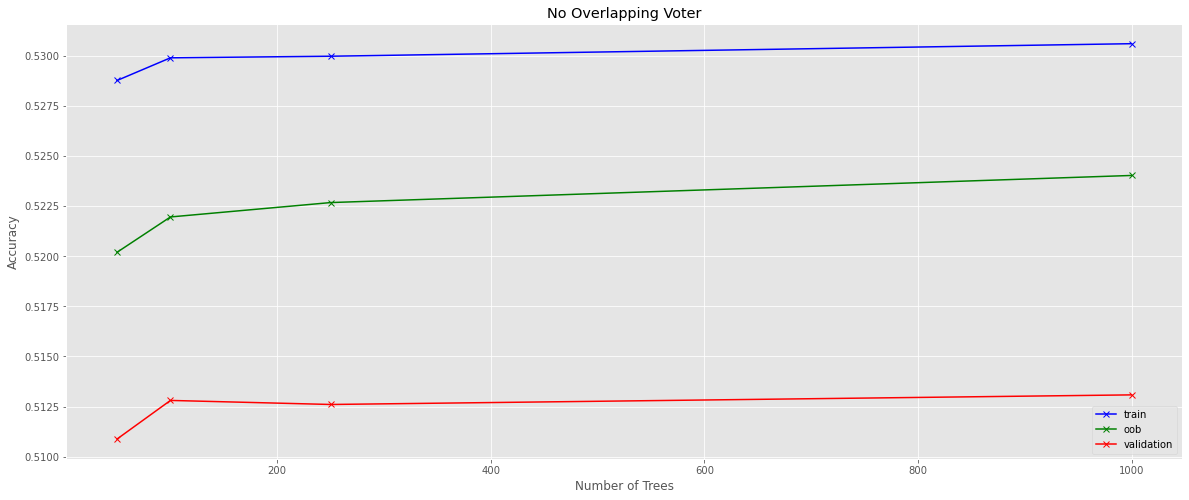

In [11]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)
    
utils.plot_results(n_trees_l, train_score, oob_score, valid_score, ['train', 'oob', 'validation'], 'No Overlapping Voter', 'Number of Trees')

In [12]:
ranked_features = utils.rank_features_by_importance(clf_nov.feature_importances_, features)

      Feature                                  Importance
 1. momentum_252_day_logret              (0.18302128839210682)
 2. mean_reversion_5_day_logret_smoothed (0.14355121186021402)
 3. overnight_sentiment_5_day_smoothed   (0.11890980168657239)
 4. market_dispersion20_day              (0.084336707582124)
 5. annualzed_volatility_120_day         (0.07811221605052404)
 6. annualzed_volatility_20_day          (0.07662119945146983)
 7. market_volatility120_day             (0.06345407748452966)
 8. market_dispersion120_day             (0.05443269438416868)
 9. market_volatility20_day              (0.05374847844023861)
10. average_dollar_volume_20_day         (0.05025324195718828)
11. average_dollar_volume_120_day        (0.04214040503343719)
12. year                                 (0.021633160672459233)
13. quarter                              (0.017891904943106125)
14. weekday                              (0.011828979008907012)
15. is_December                          (6.463305295415075

['momentum_252_day_logret']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:

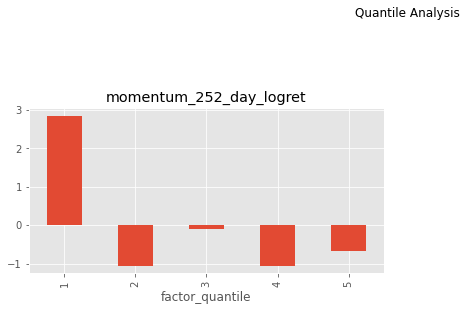

['mean_reversion_5_day_logret_smoothed']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


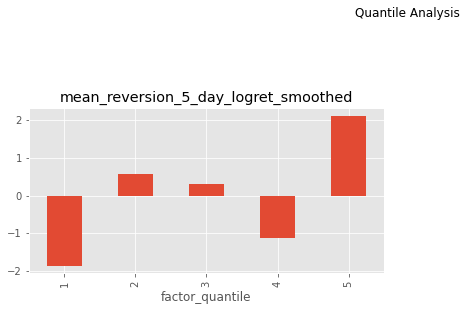

['overnight_sentiment_5_day_smoothed']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


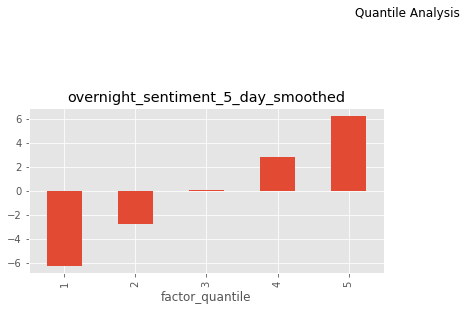

['market_dispersion20_day']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['annualzed_volatility_120_day']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


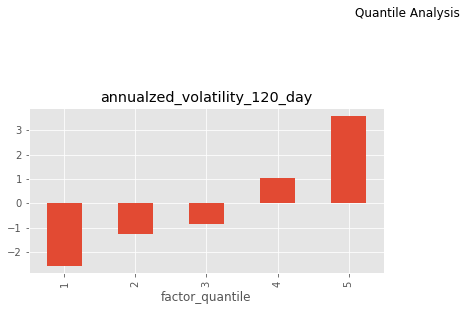

['annualzed_volatility_20_day']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


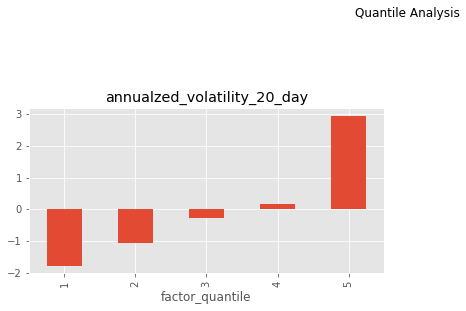

['market_volatility120_day']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['market_dispersion120_day']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['market_volatility20_day']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['average_dollar_volume_20_day']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


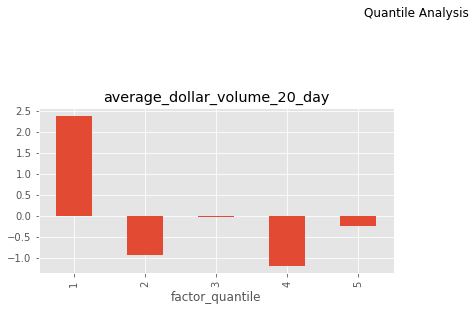

['average_dollar_volume_120_day']
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


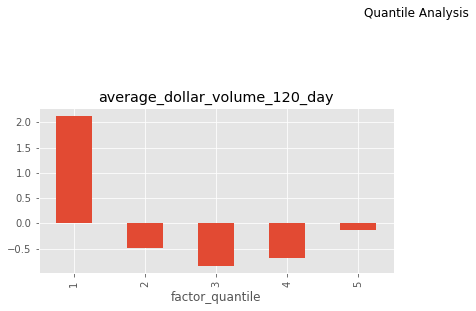

['year']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['quarter']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['weekday']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['is_December']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Issue getting clean factor data
['is_January']
Dropped 100.0% entries from factor data: 0.1% in forward returns computation and 99.9% in binning phase (set max_loss=0 to see potentially suppressed Except

In [33]:
batch_size = 1
for i in range(0,20,batch_size):
    features_to_use = ranked_features[i:i+batch_size]
    print(features_to_use)
    try:
        clean_factor_data, unixt_factor_data = alpha_factors.prepare_alpha_lense_factor_data(all_factors[features_to_use], pricing)
        alpha_factors.plot_basis_points_per_day_quantile(unixt_factor_data)
        plt.show()
    except:
        print('Issue getting clean factor data')


In [14]:
factor_names = ['overnight_sentiment_5_day_smoothed', 'annualzed_volatility_20_day', 'annualzed_volatility_120_day']

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          3.30
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

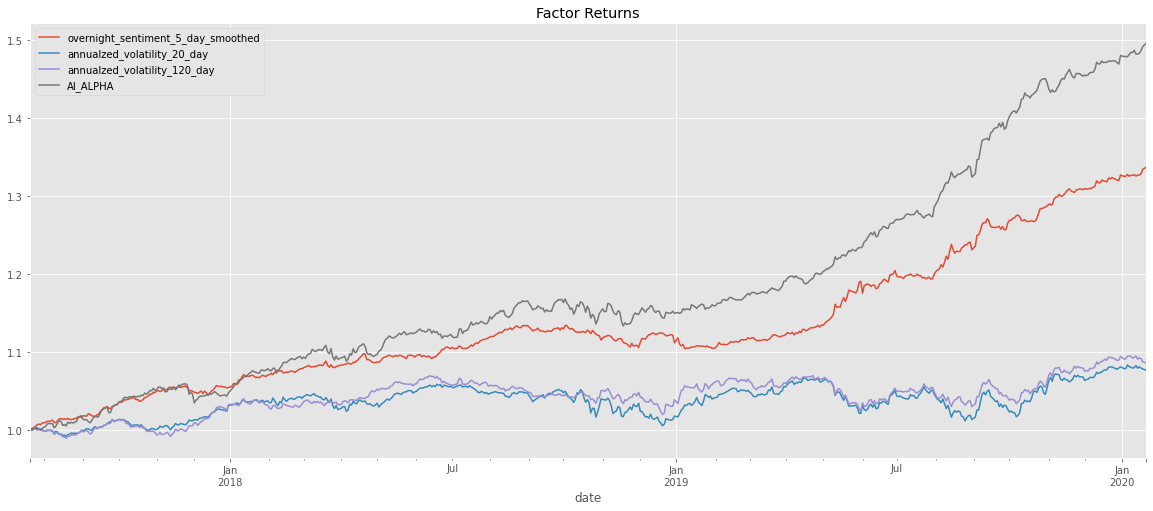

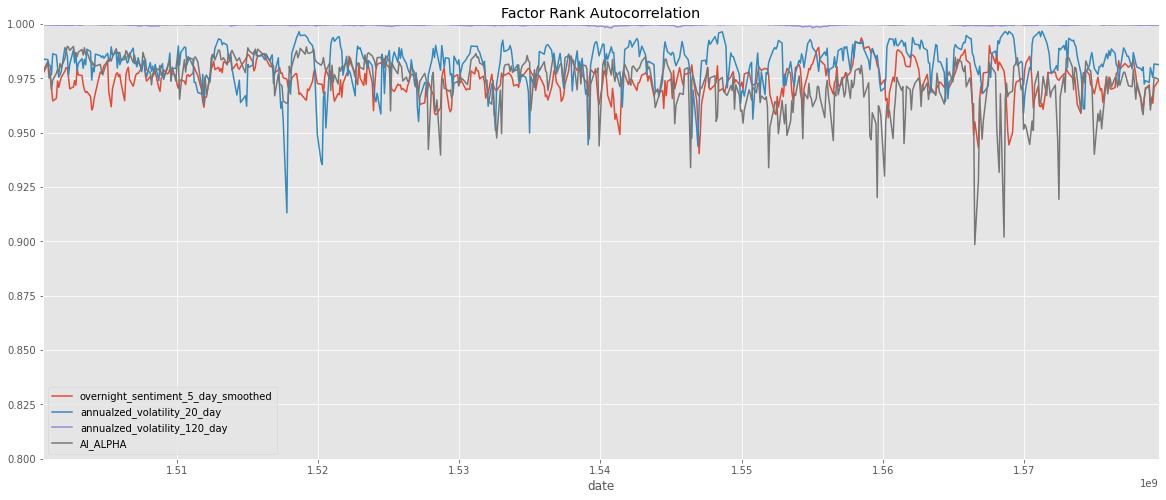

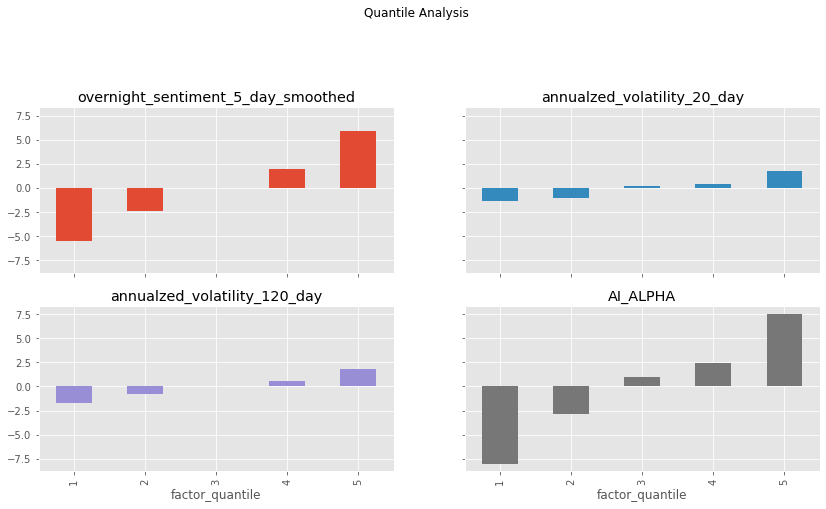

In [15]:
alpha_factors.evaluate_ai_alpha(all_factors, X_train, clf_nov, factor_names, pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          1.73
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

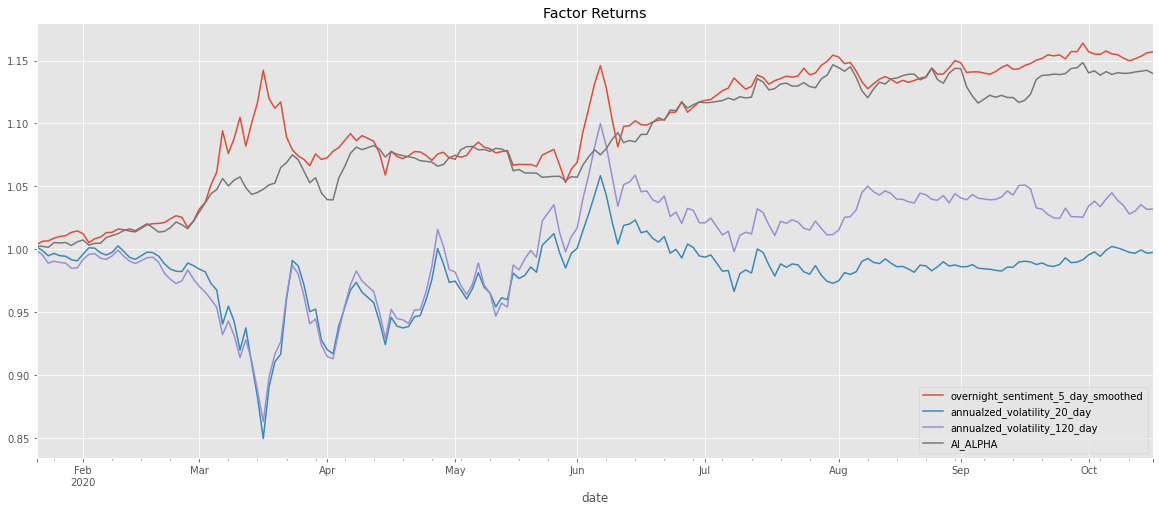

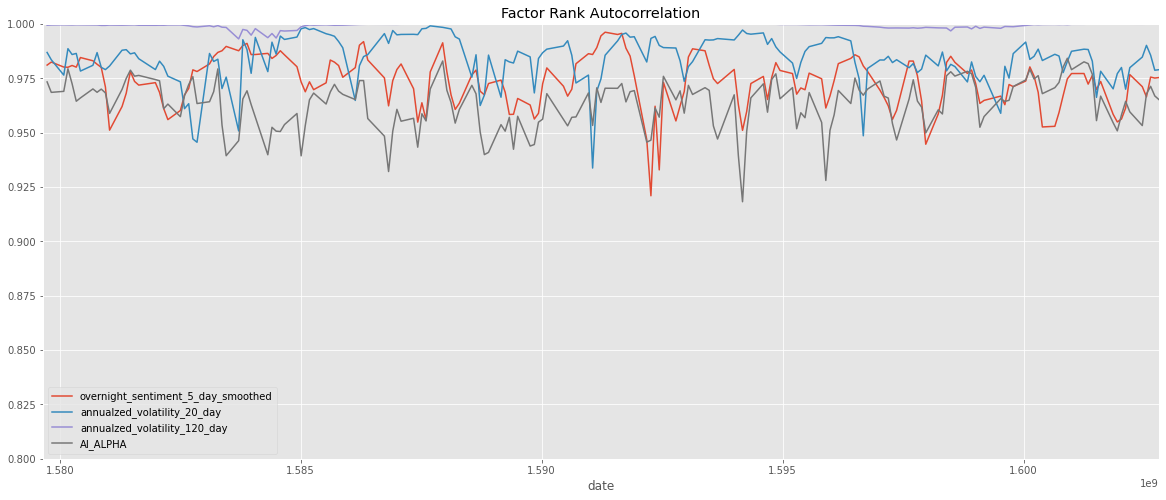

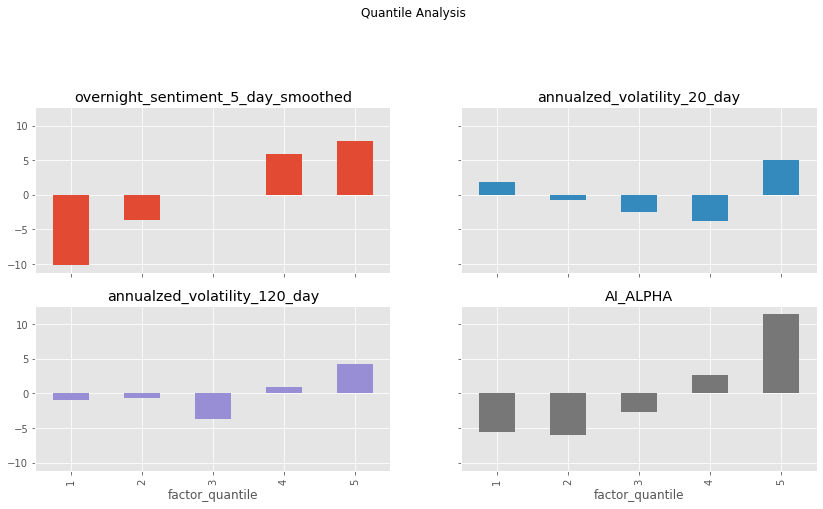

In [16]:
alpha_factors.evaluate_ai_alpha(all_factors, X_valid, clf_nov, factor_names, pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [17]:
print('Features Ranked by Average Importance:\n')
ranked_features = utils.rank_features_by_importance(clf_nov.feature_importances_, features)
ranked_features

Features Ranked by Average Importance:

      Feature                                  Importance
 1. momentum_252_day_logret              (0.18302128839210682)
 2. mean_reversion_5_day_logret_smoothed (0.14355121186021402)
 3. overnight_sentiment_5_day_smoothed   (0.11890980168657239)
 4. market_dispersion20_day              (0.084336707582124)
 5. annualzed_volatility_120_day         (0.07811221605052404)
 6. annualzed_volatility_20_day          (0.07662119945146983)
 7. market_volatility120_day             (0.06345407748452966)
 8. market_dispersion120_day             (0.05443269438416868)
 9. market_volatility20_day              (0.05374847844023861)
10. average_dollar_volume_20_day         (0.05025324195718828)
11. average_dollar_volume_120_day        (0.04214040503343719)
12. year                                 (0.021633160672459233)
13. quarter                              (0.017891904943106125)
14. weekday                              (0.011828979008907012)
15. is_December    

['momentum_252_day_logret',
 'mean_reversion_5_day_logret_smoothed',
 'overnight_sentiment_5_day_smoothed',
 'market_dispersion20_day',
 'annualzed_volatility_120_day',
 'annualzed_volatility_20_day',
 'market_volatility120_day',
 'market_dispersion120_day',
 'market_volatility20_day',
 'average_dollar_volume_20_day',
 'average_dollar_volume_120_day',
 'year',
 'quarter',
 'weekday',
 'is_December',
 'is_January',
 'quarter_start',
 'month_start',
 'month_end',
 'quarter_end']

In [18]:
features_to_use = factor_names
print(features_to_use)

['overnight_sentiment_5_day_smoothed', 'annualzed_volatility_20_day', 'annualzed_volatility_120_day']


## Read existing factors

In [19]:
all_factors = pd.read_csv('data/all_factors.csv', parse_dates=['date'])
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_assets = all_factors.index.levels[1].values.tolist()
print(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')
print(f'Stocks: {all_assets}')
all_factors.sort_values(['ticker', 'date']).tail(10)

Factors from date: 2017-07-20 00:00:00+00:00 to date: 2021-07-20 00:00:00+00:00
Stocks: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', '

,,momentum_252_day_logret,mean_reversion_5_day_logret_smoothed,overnight_sentiment_5_day_smoothed,annualzed_volatility_20_day,annualzed_volatility_120_day,average_dollar_volume_20_day,average_dollar_volume_120_day,market_dispersion20_day,market_dispersion120_day,market_volatility20_day,market_volatility120_day,is_January,is_December,weekday,quarter,year,month_start,month_end,quarter_start,quarter_end
date,ticker,,,,,,,,,,,,,,,,,,,,
2021-07-07 00:00:00+00:00,XYL,1.160476,-0.599291,1.444533,-1.631595,-1.479174,-0.938773,-1.250543,0.012881,0.016539,0.087972,0.102633,0,0,2,3,2021,0,0,0,0
2021-07-08 00:00:00+00:00,XYL,1.215902,-0.557721,1.472246,-1.610810,-1.520744,-0.938773,-1.250543,0.012832,0.016465,0.092767,0.103807,0,0,3,3,2021,0,0,0,0
2021-07-09 00:00:00+00:00,XYL,1.084266,-0.592363,1.402964,-1.700877,-1.541528,-0.917989,-1.257471,0.012729,0.016421,0.104747,0.104864,0,0,4,3,2021,0,0,0,0
2021-07-12 00:00:00+00:00,XYL,1.153548,-0.661645,1.382179,-1.659308,-1.576169,-0.924917,-1.257471,0.012669,0.016348,0.104090,0.104539,0,0,0,3,2021,0,0,0,0
2021-07-13 00:00:00+00:00,XYL,1.139692,-0.689358,1.264400,-1.631595,-1.576169,-0.904132,-1.257471,0.012586,0.016292,0.108277,0.105004,0,0,1,3,2021,0,0,0,0
2021-07-14 00:00:00+00:00,XYL,0.862563,-0.827922,1.125835,-1.596954,-1.583098,-0.876419,-1.250543,0.012697,0.016262,0.109875,0.104522,0,0,2,3,2021,0,0,0,0
2021-07-15 00:00:00+00:00,XYL,0.897204,-0.883348,0.917989,-1.465318,-1.631595,-0.876419,-1.264400,0.012811,0.016256,0.106578,0.104343,0,0,3,3,2021,0,0,0,0
2021-07-16 00:00:00+00:00,XYL,0.945702,-0.959558,0.668573,-1.299041,-1.652380,-0.869491,-1.264400,0.012416,0.016236,0.105082,0.105340,0,0,4,3,2021,0,0,0,0
2021-07-19 00:00:00+00:00,XYL,0.973415,-0.987271,0.453798,-1.354466,-1.680093,-0.883348,-1.271328,0.012572,0.016181,0.106672,0.107164,0,0,0,3,2021,0,0,0,0


In [20]:
prod_target_source = '5Day5Quant'
forward_prediciton_days = 5

all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, 5, 5).for_al(prod_target_source),
], axis=1).dropna()
all_factors.sort_index(inplace=True)
display(all_factors.head())

all_factors['target'] = all_factors.groupby(level=1)[prod_target_source].shift(-forward_prediciton_days)
all_factors[[prod_target_source,'target']].reset_index().sort_values(['ticker', 'date']).head(10)

momentum_252_day_logret  \
date                      ticker                            
2017-07-20 00:00:00+00:00 A                      0.710144   
                          AAL                    1.229761   
                          AAP                   -1.687024   
                          AAPL                   1.396039   
                          ABBV                   0.072746   

                                  mean_reversion_5_day_logret_smoothed  \
date                      ticker                                         
2017-07-20 00:00:00+00:00 A                                  -0.779426   
                          AAL                                -1.638527   
                          AAP                                 1.728594   
                          AAPL                               -1.139694   
                          ABBV                               -0.495369   

                                  overnight_sentiment_5_day_smoothed  \
date                      ticker                                       
2017-07-20 00:00:00+00:00 A                                 1.292112   
                          AAL                               0.675501   
                          AAP                              -1.132763   
                          AAPL                             -1.451461   
                          ABBV                             -0.917989   

                                  annualzed_volatility_20_day  \
date                      ticker                                
2017-07-20 00:00:00+00:00 A                         -0.239024   
                          AAL                        0.807139   
                          AAP                        1.520747   
                          AAPL                       1.264402   
                          ABBV                       0.647790   

                                  annualzed_volatility_120_day  \
date                      ticker                                 
2017-07-20 00:00:00+00:00 A                           0.287522   
                          AAL                         0.419158   
                          AAP                         1.603885   
                          AAPL                       -0.620077   
                          ABBV                        0.370660   

                                  average_dollar_volume_20_day  \
date                      ticker                                 
2017-07-20 00:00:00+00:00 A                          -0.412230   
                          AAL                         1.035771   
                          AAP                         0.793282   
                          AAPL                        1.728594   
                          ABBV                        1.195120   

                                  average_dollar_volume_120_day  \
date                      ticker                                  
2017-07-20 00:00:00+00:00 A                           -0.550794   
                          AAL                          1.021914   
                          AAP                          0.495369   
                          AAPL                         1.728594   
                          ABBV                         1.250546   

                                  market_dispersion20_day  \
date                      ticker                            
2017-07-20 00:00:00+00:00 A                      0.012224   
                          AAL                    0.012224   
                          AAP                    0.012224   
                          AAPL                   0.012224   
                          ABBV                   0.012224   

                                  market_dispersion120_day  \
date                      ticker                             
2017-07-20 00:00:00+00:00 A                       0.012114   
                          AAL                     0.012114   
                          AAP                     0.01

,date,ticker,5Day5Quant,target
0,2017-07-20 00:00:00+00:00,A,1,1.0
500,2017-07-21 00:00:00+00:00,A,1,0.0
1000,2017-07-24 00:00:00+00:00,A,1,0.0
1500,2017-07-25 00:00:00+00:00,A,0,1.0
2000,2017-07-26 00:00:00+00:00,A,0,3.0
2500,2017-07-27 00:00:00+00:00,A,1,3.0
3000,2017-07-28 00:00:00+00:00,A,0,2.0
3500,2017-07-31 00:00:00+00:00,A,0,4.0
4000,2017-08-01 00:00:00+00:00,A,1,3.0
4500,2017-08-02 00:00:00+00:00,A,3,1.0


In [21]:
temp = all_factors.dropna().copy()
X = temp[features_to_use]
y = temp['target']

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_valid_test_split(X, y, 0.7, 0.15, 0.15)

1.0


In [22]:
clf = RandomForestClassifier(2000, **clf_parameters)

clf_nov = NoOverlapVoter(clf)
clf_nov.fit(X, y)

NoOverlapVoter(estimator=RandomForestClassifier(criterion='entropy',
                                                min_samples_leaf=4000,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True,
                                                random_state=42))

### Results
#### Accuracy

In [23]:
print('train: {}, oob: {}, valid: {}, test:{}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.score(X_test, y_test.values),
    clf_nov.oob_score_))

train: 0.23003492063492065, oob: 0.23237234042553193, valid: 0.23630434782608695, test:0.22944672636815916


#### Train

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          3.30
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

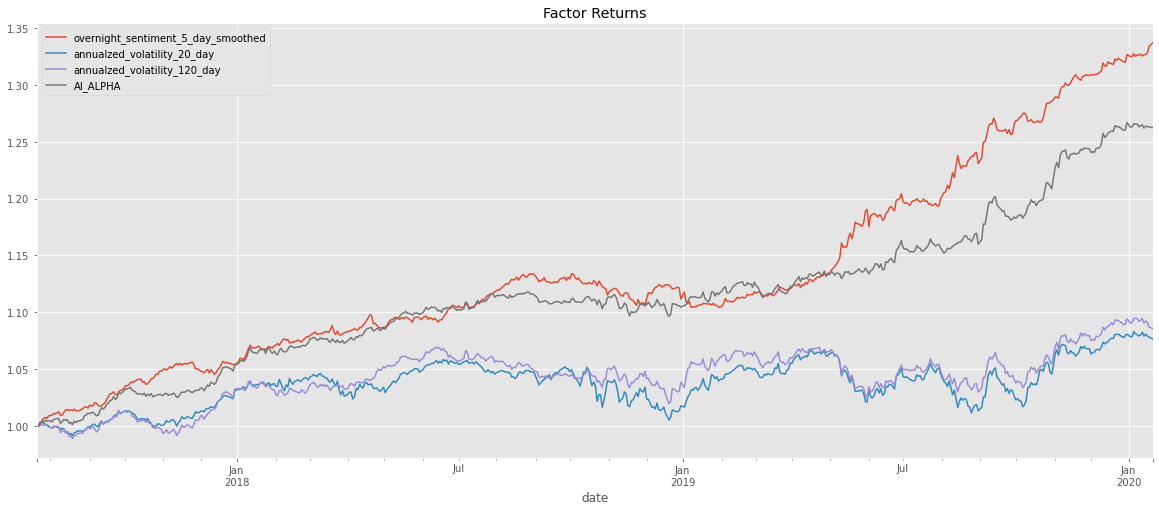

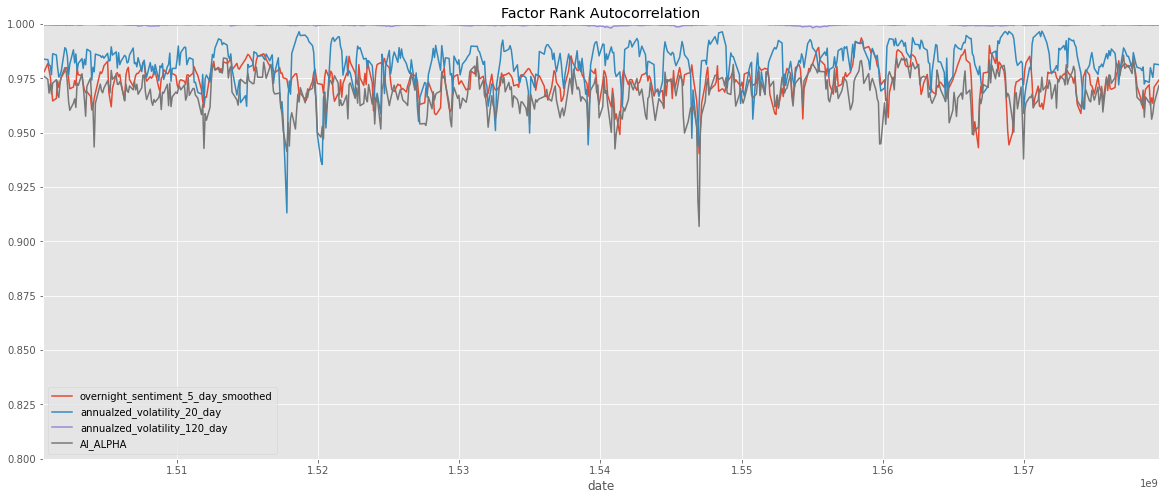

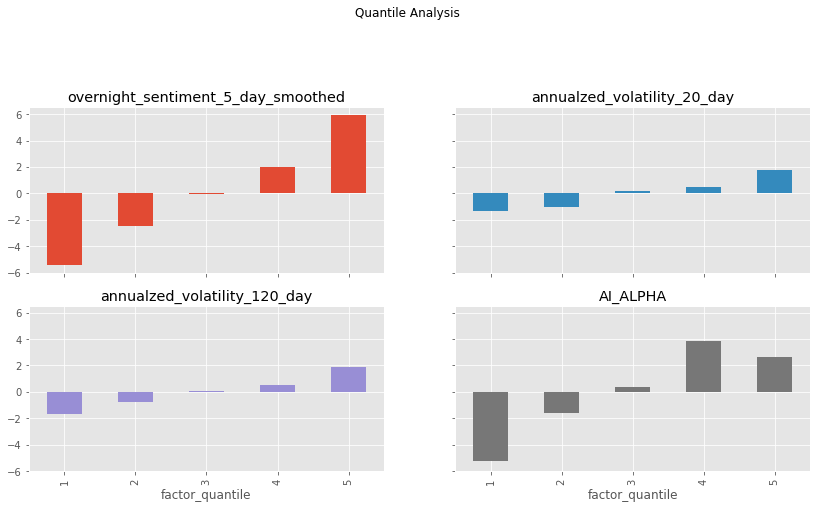

In [24]:
alpha_factors.evaluate_ai_alpha(all_factors, X_train, clf_nov, features_to_use, pricing)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          1.73
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

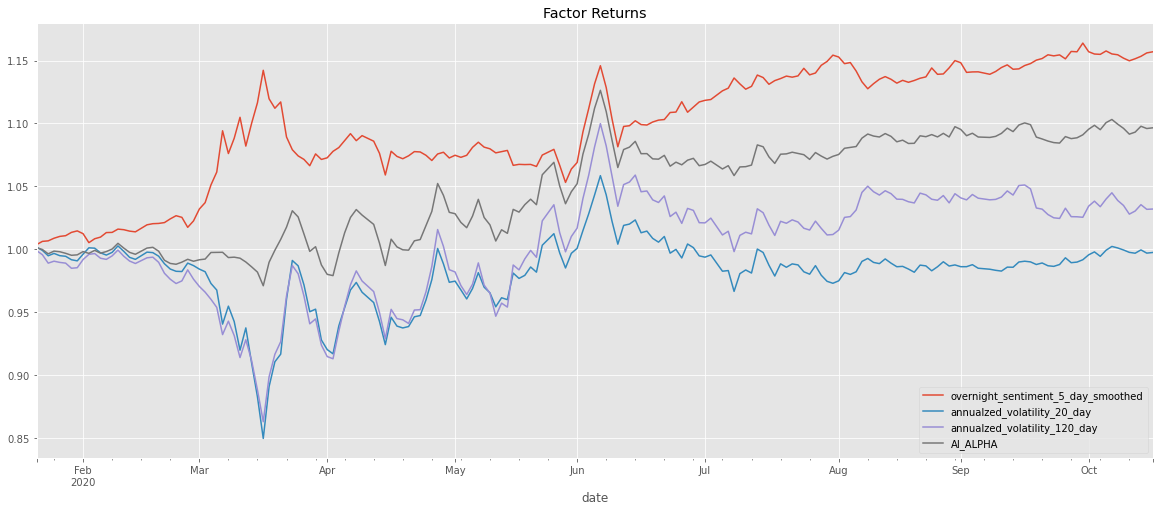

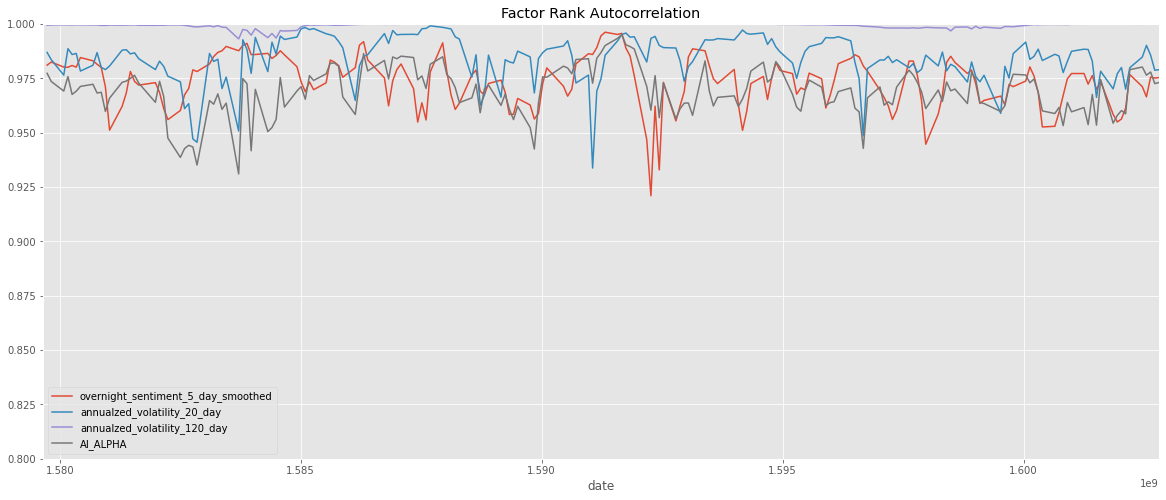

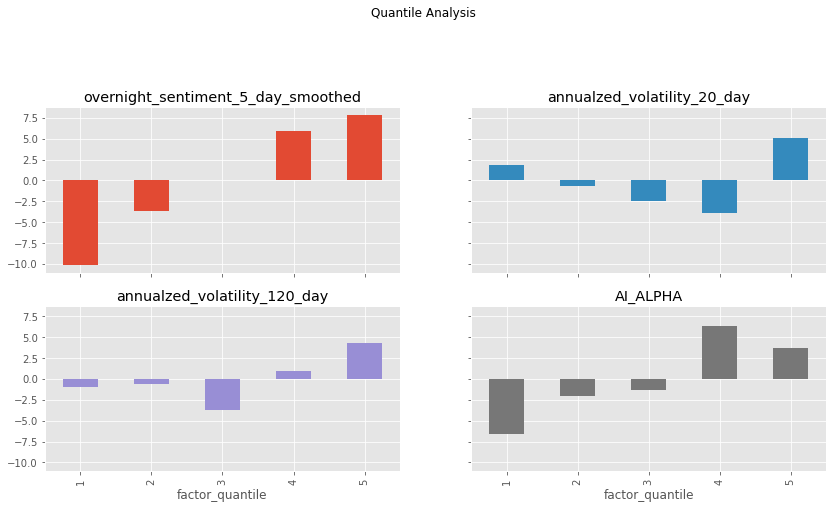

In [25]:
alpha_factors.evaluate_ai_alpha(all_factors, X_valid, clf_nov, features_to_use, pricing)

#### Test

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          1.51
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

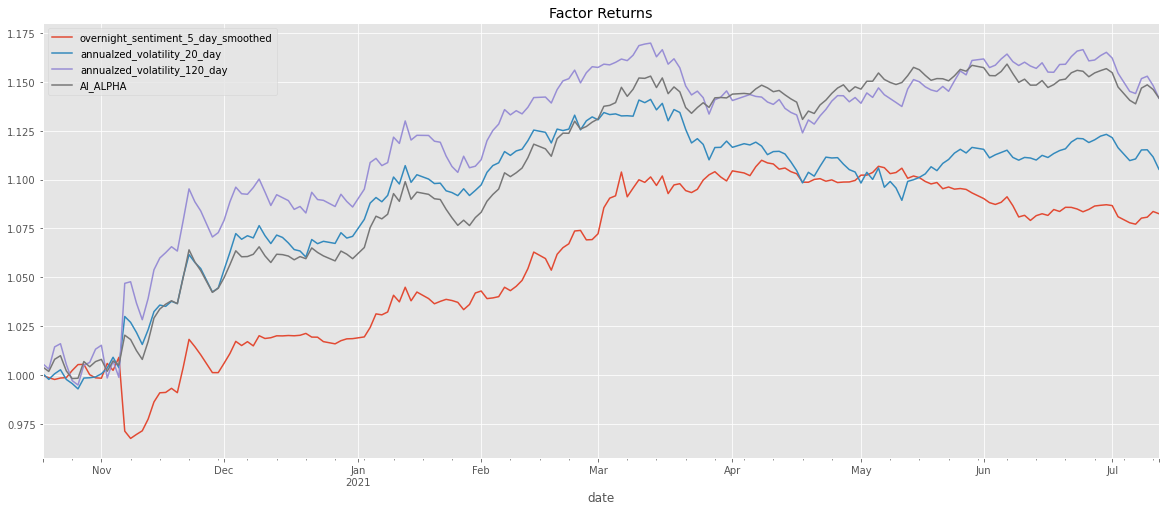

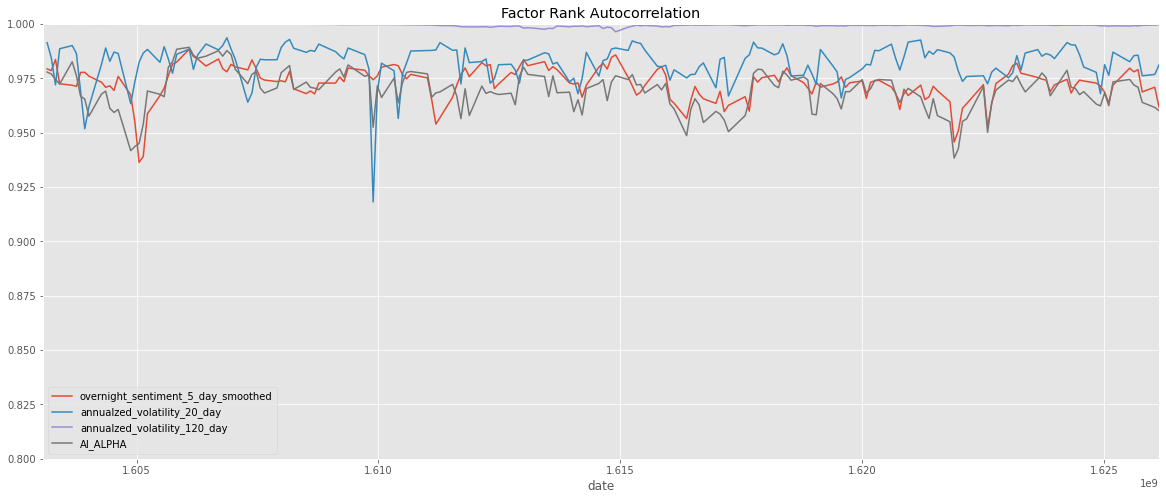

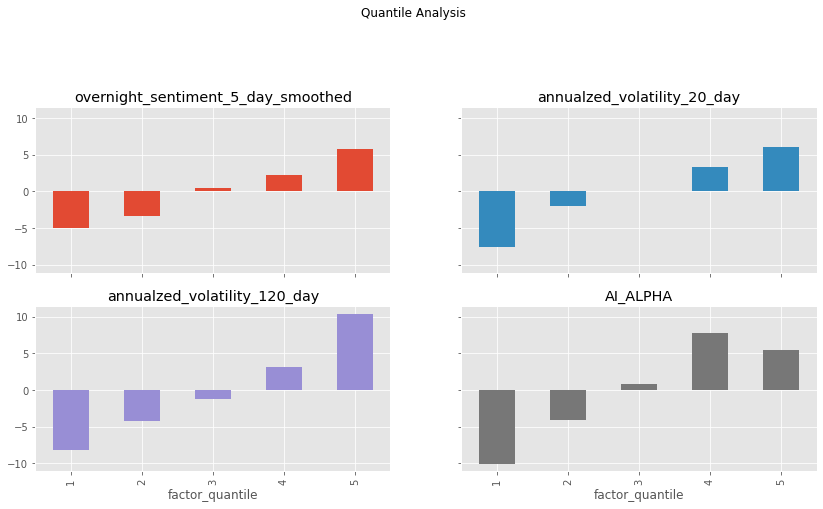

In [26]:
alpha_factors.evaluate_ai_alpha(all_factors, X_test, clf_nov, features_to_use, pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------

             Sharpe Ratios
                                    Sharpe Ratio
overnight_sentiment_5_day_smoothed          2.00
annualzed_volatility_20_day                

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: Matplotli

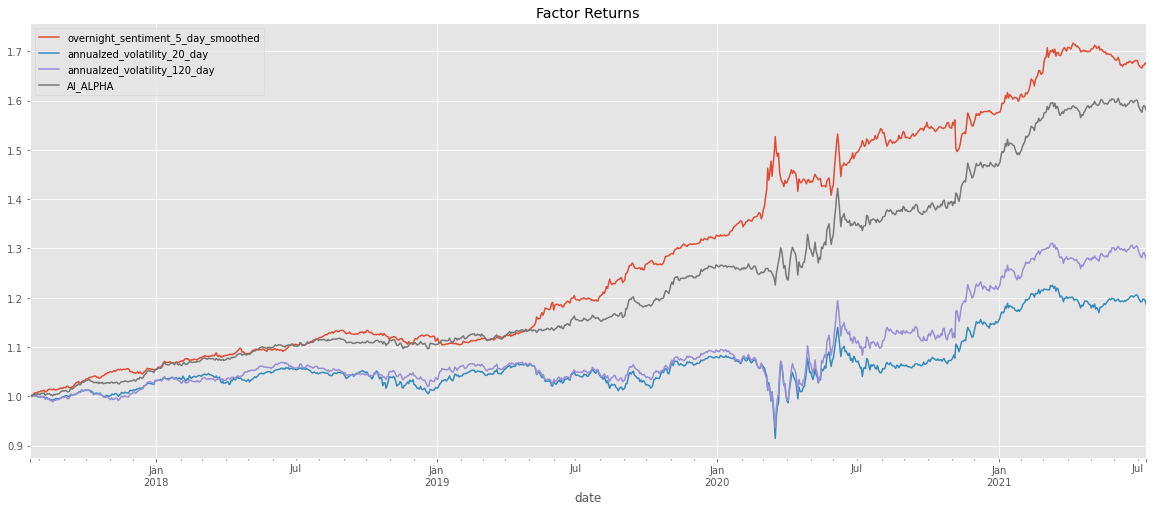

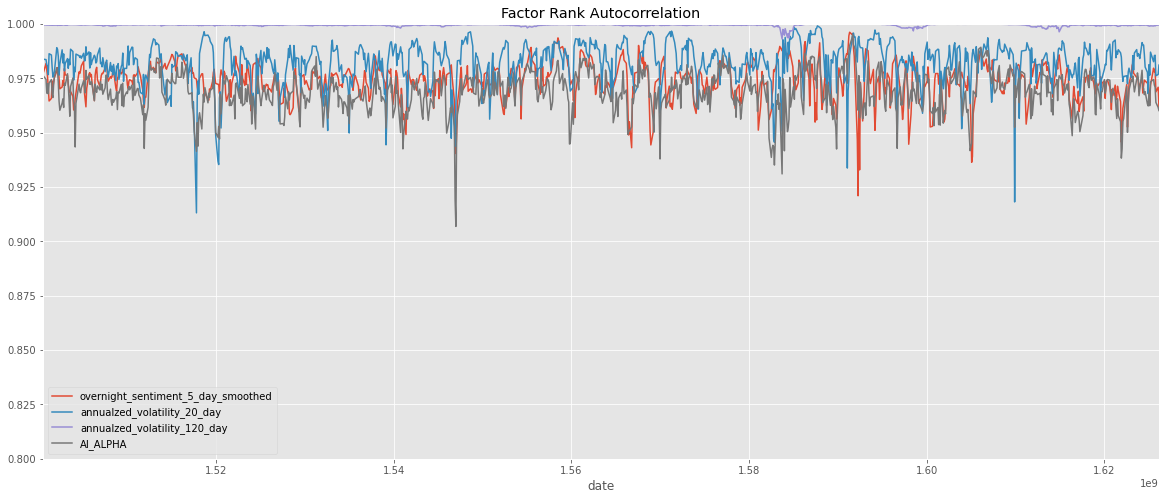

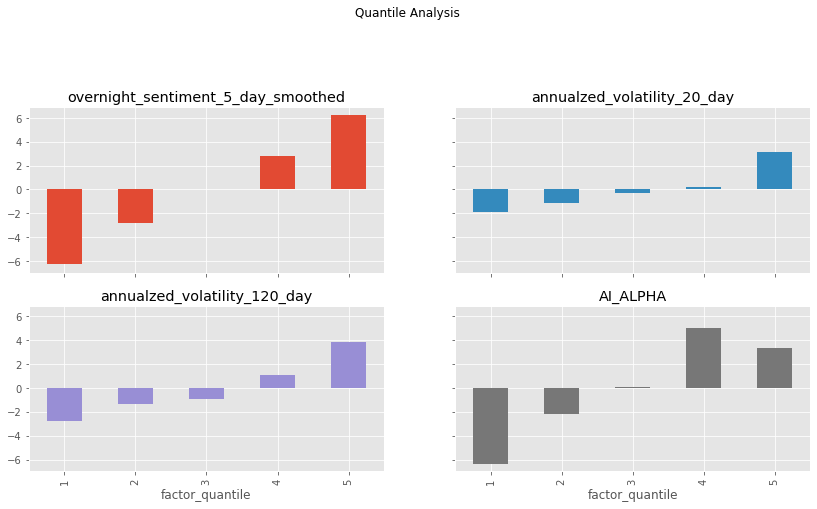

In [27]:
ai_alpha = alpha_factors.evaluate_ai_alpha(all_factors, X, clf_nov, features_to_use, pricing)

## Model evaluation

This looks like a pretty good model. Let's generate the alpha vectors for each day and save them

In [28]:
all_factors = pd.read_csv('data/all_factors.csv', parse_dates=['date'])
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_assets = all_factors.index.levels[1].values.tolist()
print(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')

Factors from date: 2017-07-20 00:00:00+00:00 to date: 2021-07-20 00:00:00+00:00


In [29]:
alpha_scores = alpha_factors.compute_ai_alpha_score(all_factors[features_to_use], clf_nov)

In [30]:
ai_alpha = pd.DataFrame(alpha_scores, index=all_factors.index, columns=['AI_ALPHA']).reset_index()
ai_alpha['date'] = ai_alpha['date'].dt.date
alpha_vectors = ai_alpha.reset_index().pivot(index='date', columns='ticker', values='AI_ALPHA')
alpha_vectors

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL
date,,,,,,,,,,,,,,,,,,,,,
2017-07-20,0.010104,0.008523,-0.002008,-0.011589,0.004715,0.014182,0.018817,0.000910,-0.026109,-0.005769,...,-0.014088,-0.012568,-0.004681,-0.028486,-0.001168,0.004726,0.018071,-0.038363,-0.009975,-0.007960
2017-07-21,0.007832,0.006257,-0.001539,-0.009790,0.006509,0.013849,0.015522,0.005275,-0.019318,-0.005435,...,-0.019255,-0.014727,-0.005808,-0.030544,0.003097,0.003981,0.014838,-0.035355,-0.008585,-0.008983
2017-07-24,0.007589,0.005125,-0.000016,-0.008800,0.007947,0.012499,0.015241,0.003629,-0.016036,-0.005723,...,-0.020745,-0.013501,-0.006159,-0.029058,0.013896,0.002332,0.010648,-0.029465,-0.006497,-0.007391
2017-07-25,0.006283,0.005772,0.005595,-0.007942,0.008977,0.009243,0.015162,-0.000628,-0.011029,-0.004961,...,-0.018765,-0.010861,-0.007669,-0.020657,0.020919,-0.000278,0.001886,-0.030125,-0.010875,-0.007559
2017-07-26,-0.000832,0.007924,0.008930,-0.005361,0.008375,0.002639,0.015995,-0.003975,-0.009891,-0.005009,...,-0.019874,-0.012256,-0.006068,-0.018656,0.019760,-0.002325,0.002040,-0.025761,-0.014812,-0.007120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-14,0.007196,0.009404,0.014772,-0.002461,-0.021739,-0.027044,-0.000068,-0.016549,-0.015140,0.006061,...,-0.008518,0.005337,-0.007591,-0.010221,0.016613,-0.008991,0.024506,-0.001109,-0.011014,-0.008998
2021-07-15,0.011974,0.015298,0.015698,0.004909,-0.016004,-0.026715,0.000775,-0.015047,-0.009025,0.007866,...,-0.012775,0.008085,-0.005884,-0.007740,0.016587,-0.004681,0.025435,-0.003047,-0.009465,-0.011239
2021-07-16,0.013246,0.015346,0.007487,0.011640,-0.015499,-0.027307,0.005747,-0.011881,-0.006492,0.008180,...,-0.012103,0.006899,-0.002758,-0.009210,0.010451,0.001303,0.017425,-0.003115,-0.008571,-0.017608


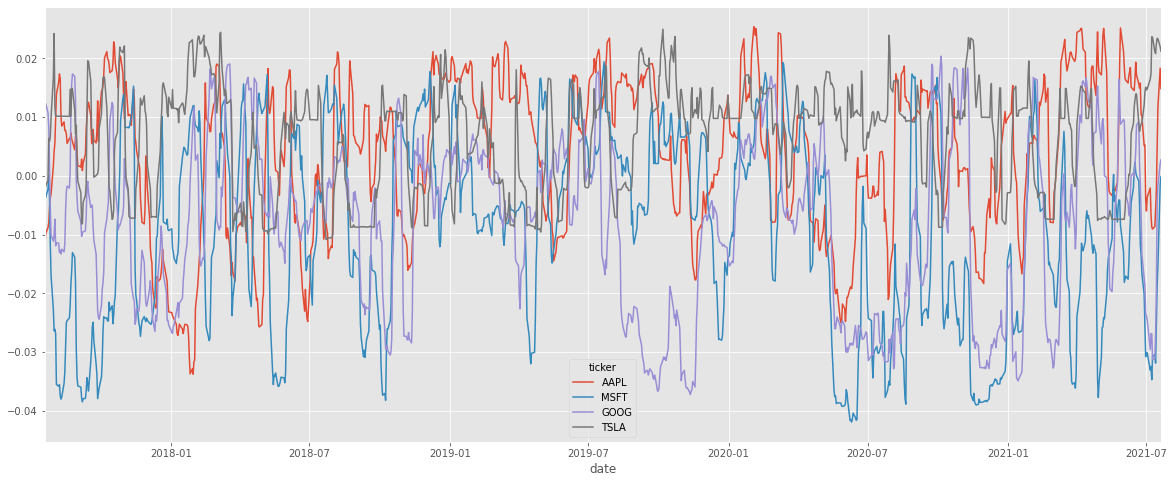

In [31]:
alpha_vectors[['AAPL', 'MSFT', 'GOOG', 'TSLA',]].plot()

In [32]:
alpha_vectors.reset_index().to_csv('data/alpha_vectors.csv', index=False)